In [1]:
#reload the modules before running the program
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
from scipy import signal
from scipy.fft import fftshift
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import math
import cv2

In [2]:
from datasets import RFData, CameraData, SignalDataset, FuseDatasets
import metrics
import utils

In [3]:
np.random.seed(0)
torch.manual_seed(0)
data_path = r"D:\osa_new_proc_rev"
# trial_folders = ["v_12_5", "v_13_5", "v_13_10"]
trial_folders = os.listdir(data_path)

# train_idxs = np.linspace(0, 49, 50, dtype=int)
train_folders = trial_folders#[trial_folders[i] for i in train_idxs]
# test_folders = [trial_folders[i] for i in range(len(trial_folders)) if i not in train_idxs]


thermal_file_name = "Thermal_Camera"
num_samps_oversample = 20 # per experiment, number of samples to generate
data_length = 9000
fs = 25
out_len = 1800 # sample length generated
thermal_ext = ".npy"

dataset_thermal_train = CameraData(data_path, train_folders, thermal_file_name, num_samps_oversample, fs, data_length, out_len, thermal_ext)
# dataset_thermal_test = CameraData(data_path, test_folders, thermal_file_name, num_samps_oversample, fs, data_length, out_len, thermal_ext)

In [4]:
samp_f=5e6
freq_slope=60.012e12
samples_per_chirp=256
num_tx = 3
num_rx = 4
radar_file_name = "FMCW_Radar.npy"
window_size = 25 # number of range bins to use

dataset_radar_train = RFData(data_path, train_folders, data_length, radar_file_name, out_len, window_size, samples_per_chirp, samp_f, freq_slope, num_samps_oversample, num_tx, num_rx, fs)
# dataset_radar_test = RFData(data_path, test_folders, data_length, radar_file_name, out_len, window_size, samples_per_chirp, samp_f, freq_slope, num_samps_oversample, num_tx, num_rx, fs)

100%|██████████| 245/245 [03:27<00:00,  1.18it/s]


In [5]:
np.random.seed(0)
torch.manual_seed(0)
vital_dict_file_name = "gt_dict.pkl"
vital_key_radar = "CHEST"
vital_key_thermal = "AIR_flow"
l_freq_bpm = 5
u_freq_bpm = 30
dataset_OSA_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'OSA', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_CSA_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'CSA', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_MSA_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'MSA', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_hypopnea_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'Hypopnea', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_partial_apnea_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'Partial_Apnea', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_gt_thermal_train = SignalDataset(data_path, train_folders, vital_dict_file_name, vital_key_thermal, data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)
dataset_gt_radar_train = SignalDataset(data_path, train_folders, vital_dict_file_name, vital_key_radar, data_length, out_len, True, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)

# dataset_apnea_test = SignalDataset(data_path, test_folders, vital_dict_file_name, 'Sleep_Apnea', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
#                               normalize=False)
# dataset_gt_thermal_test = SignalDataset(data_path, test_folders, vital_dict_file_name, vital_key_thermal, data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)
# dataset_gt_radar_test = SignalDataset(data_path, test_folders, vital_dict_file_name, vital_key_radar, data_length, out_len, True, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)

In [6]:
np.random.seed(0)
torch.manual_seed(0)
fused_dataset_train = FuseDatasets([dataset_radar_train, dataset_thermal_train, dataset_gt_radar_train, dataset_gt_thermal_train, dataset_OSA_train, dataset_CSA_train, dataset_hypopnea_train, dataset_partial_apnea_train], ["radar", "thermal", "gt_radar", "gt_ir", "gt_OSA", "gt_CSA", "hypopnea", "partial_apnea"], out_len=out_len)
# fused_dataset_test = FuseDatasets([dataset_radar_test, dataset_thermal_test, dataset_gt_radar_test, dataset_gt_thermal_test, dataset_apnea_test], ["radar", "thermal", "gt_radar", "gt_ir", "gt_apnea"], out_len=out_len)
t_arr = np.linspace(0, out_len/fs, out_len)

In [3]:
fs = 30
out_len = 1800
t_arr = np.linspace(0, out_len/fs, out_len)

In [4]:
# NUKS_idx = np.load(r"E:\OSA_project\Emir_Clean\saved_idx\NUKS_idx.npy")
# mode_lock_idx = np.load(r"E:\OSA_project\Emir_Clean\saved_idx\mode_lock_idx.npy")
# movement_idx = np.load(r"E:\OSA_project\Emir_Clean\saved_idx\movement_idx.npy")
X = np.load(r"E:\OSA_project\Emir_Clean\saved_data\thermal_arr.npy")
y = np.load(r"E:\OSA_project\Emir_Clean\saved_data\gt_arr.npy")


In [15]:
label_y = np.zeros(len(y))

for i in tqdm(range(len(label_y))):
    if((np.mean(y[i][1]) > 0.1) or (np.mean(y[i][2] > 0.1))):
        label_y[i] = 1

100%|██████████| 3436/3436 [00:00<00:00, 27561.28it/s]


In [16]:
def hyperparam_tuning(th_arr, window_dmax_arr, window_dmin_arr, modes, X, y):
    full_arr = []
    prod_arr = []
    for th in tqdm(th_arr):
        for window_max in tqdm(window_dmax_arr):
            for window_min in window_dmin_arr:
                for mode in modes:
                    gt_arr = []
                    pred_arr = []
                
                    for idx in range(len(X)):
                            pred = utils.predict(X[idx], dmin=window_min, dmax=window_max, th=th, mode=mode, plot=False)

                            gt_OSA = y[idx][1]
                            gt_CSA = y[idx][2]
                            # gt_hp = gt_hypopnea[idx]

                            if((np.mean(gt_OSA) > 0.1) or (np.mean(gt_CSA) > 0.1)):# or (np.mean(gt_hp) > 0.1)):
                                gt_arr.append(1)
                            else:
                                gt_arr.append(0)
                            
                            if(np.mean(pred) > 0.1):
                                pred_arr.append(1)
                            else:
                                pred_arr.append(0)

                    precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))                    
                    prod_arr.append(precision*recall / (precision + recall))
                    full_arr.append((th, mode, window_min, window_max, recall, precision, accuracy, confusion_matrix))
    if(len(prod_arr) > 1):
        for i in range(len(prod_arr)):
            if(math.isnan(prod_arr[i])):
                prod_arr[i] = 0
        
        best_idxs = np.argsort(prod_arr)[::-1]
        return((prod_arr[best_idxs[0]], full_arr[best_idxs[0]]))
    else:
        return(prod_arr[0], full_arr[0])
    

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
# Assuming you have your features in X and labels in y

# Create an instance of StratifiedKFold with the desired number of folds
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
training_scores = []
training_params = []
test_scores = []
# Perform stratified k-fold cross validation
for train_index, test_index in skf.split(X, label_y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train and evaluate your model on the current fold
    # Replace this with your own model training and evaluation code
    f1_score, params = hyperparam_tuning(th_arr=np.linspace(0.1,0.4, 20), window_dmax_arr=np.linspace(15,40, 20), window_dmin_arr=np.linspace(15,40, 20), modes='90th', X=X_train, y=y_train)
    training_scores.append(f1_score)
    training_params.append(params)
    f1_score_test, _ = hyperparam_tuning(th_arr=[params[0]], window_dmin_arr=[params[1]], window_dmax_arr=[params[2]], modes='90th', X=X_test, y=y_test)
    
    # Print the accuracy for the current fold
    print("f1_score_test:", f1_score_test, '\n')
    print("th: ", params[0], "mode: ", mode, "dmin: ", window_min, "dmax: ", window_max, '\n')
    print("recall: ", recall, "precision: ", precision, "accuracy: ", accuracy, "confusion_matrix: ", confusion_matrix))

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [26]:
np.random.randint(15,40, 10)

array([30, 17, 38, 23, 22, 16, 37, 39, 27, 19])

In [32]:
# Create an instance of StratifiedKFold with the desired number of folds
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
training_scores = []
training_params = []
test_scores = []
# Perform stratified k-fold cross validation
for train_index, test_index in skf.split(X, label_y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train and evaluate your model on the current fold
    # Replace this with your own model training and evaluation code
    f1_score, params = hyperparam_tuning(th_arr=np.linspace(0.1,0.4,10), window_dmax_arr=np.linspace(15,40, 10, dtype=int), window_dmin_arr=np.linspace(15,40, 10, dtype=int),  modes=['90th'], X=X_train, y=y_train)
    training_scores.append(f1_score)
    training_params.append(params)
    f1_score_test, _ = hyperparam_tuning(th_arr=[params[0]], window_dmin_arr=[params[2]], window_dmax_arr=[params[3]], modes=['90th'], X=X_test, y=y_test)

    # Print the accuracy for the current fold
    print("f1_score_test:", f1_score_test, '\n')
    print("th: ", params[0], "mode: ", params[1], "dmin: ", params[2], "dmax: ", params[3], '\n')
    print("recall: ", params[4], "precision: ", params[5], "accuracy: ", params[6], "confusion_matrix: ", params[7])

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\111\AppData\Local\Temp/ipykernel_23920/195897019.py:29: RuntimeWarning: invalid value encountered in double_scalars
  prod_arr.append(precision*recall / (precision + recall))
e:\OSA_project\Emir_Clean\utils.py:42: RuntimeWarning: invalid value encountered in long_scalars
  accuracy = (tp + tn)/ (tp + tn + fp + fn)
100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


f1_score_test: nan 

th:  0.2666666666666667 mode:  90th dmin:  17 dmax:  20 

recall:  0.12727272727272726 precision:  0.6363636363636364 accuracy:  0.9810771470160117 confusion_matrix:  [[   7   48]
 [   4 2689]]


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


f1_score_test: 0.05 

th:  0.30000000000000004 mode:  90th dmin:  15 dmax:  17 

recall:  0.12727272727272726 precision:  0.3333333333333333 accuracy:  0.9774463441251364 confusion_matrix:  [[   7   48]
 [  14 2680]]


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


f1_score_test: 0.0967741935483871 

th:  0.4 mode:  90th dmin:  15 dmax:  17 

recall:  0.18518518518518517 precision:  0.16393442622950818 accuracy:  0.9654419789014187 confusion_matrix:  [[  10   44]
 [  51 2644]]


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


f1_score_test: nan 

th:  0.2666666666666667 mode:  90th dmin:  17 dmax:  20 

recall:  0.12727272727272726 precision:  0.7 accuracy:  0.981447799199709 confusion_matrix:  [[   7   48]
 [   3 2691]]


 90%|█████████ | 9/10 [38:25<04:17, 257.77s/it]

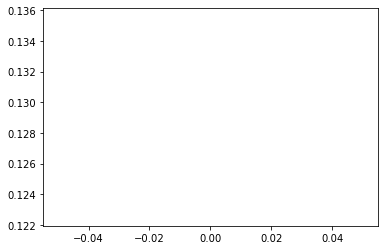

In [31]:
plt.plot(f1_score_test)